
Dataset Summary:
--------------------------------------------------
Total passengers: 50000

Overall no-show rate: 15.6%

No-show rates by age group:
age
(0, 25]      0.194834
(25, 35]     0.124830
(35, 55]     0.101969
(55, 100]    0.249674
Name: no_show, dtype: float64

No-show rates by regular traveler status:
is_regular
0    0.183098
1    0.114788
Name: no_show, dtype: float64

No-show rates by booking time:
days_before_flight
(0, 7]       0.133946
(7, 30]      0.148369
(30, 90]     0.170774
(90, 180]    0.224590
Name: no_show, dtype: float64


<ipython-input-1-216ea86fef67>:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups = df.groupby(pd.cut(df['age'], [0, 25, 35, 55, 100]))['no_show'].mean()
<ipython-input-1-216ea86fef67>:137: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  booking_groups = df.groupby(pd.cut(df['days_before_flight'], [0, 7, 30, 90, 180]))['no_show'].mean()



Dataset saved to 'pnr_dataset.csv'


<ipython-input-1-216ea86fef67>:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_rates = df.groupby('age_group')['no_show'].mean()
<ipython-input-1-216ea86fef67>:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  booking_rates = df.groupby('booking_group')['no_show'].mean()


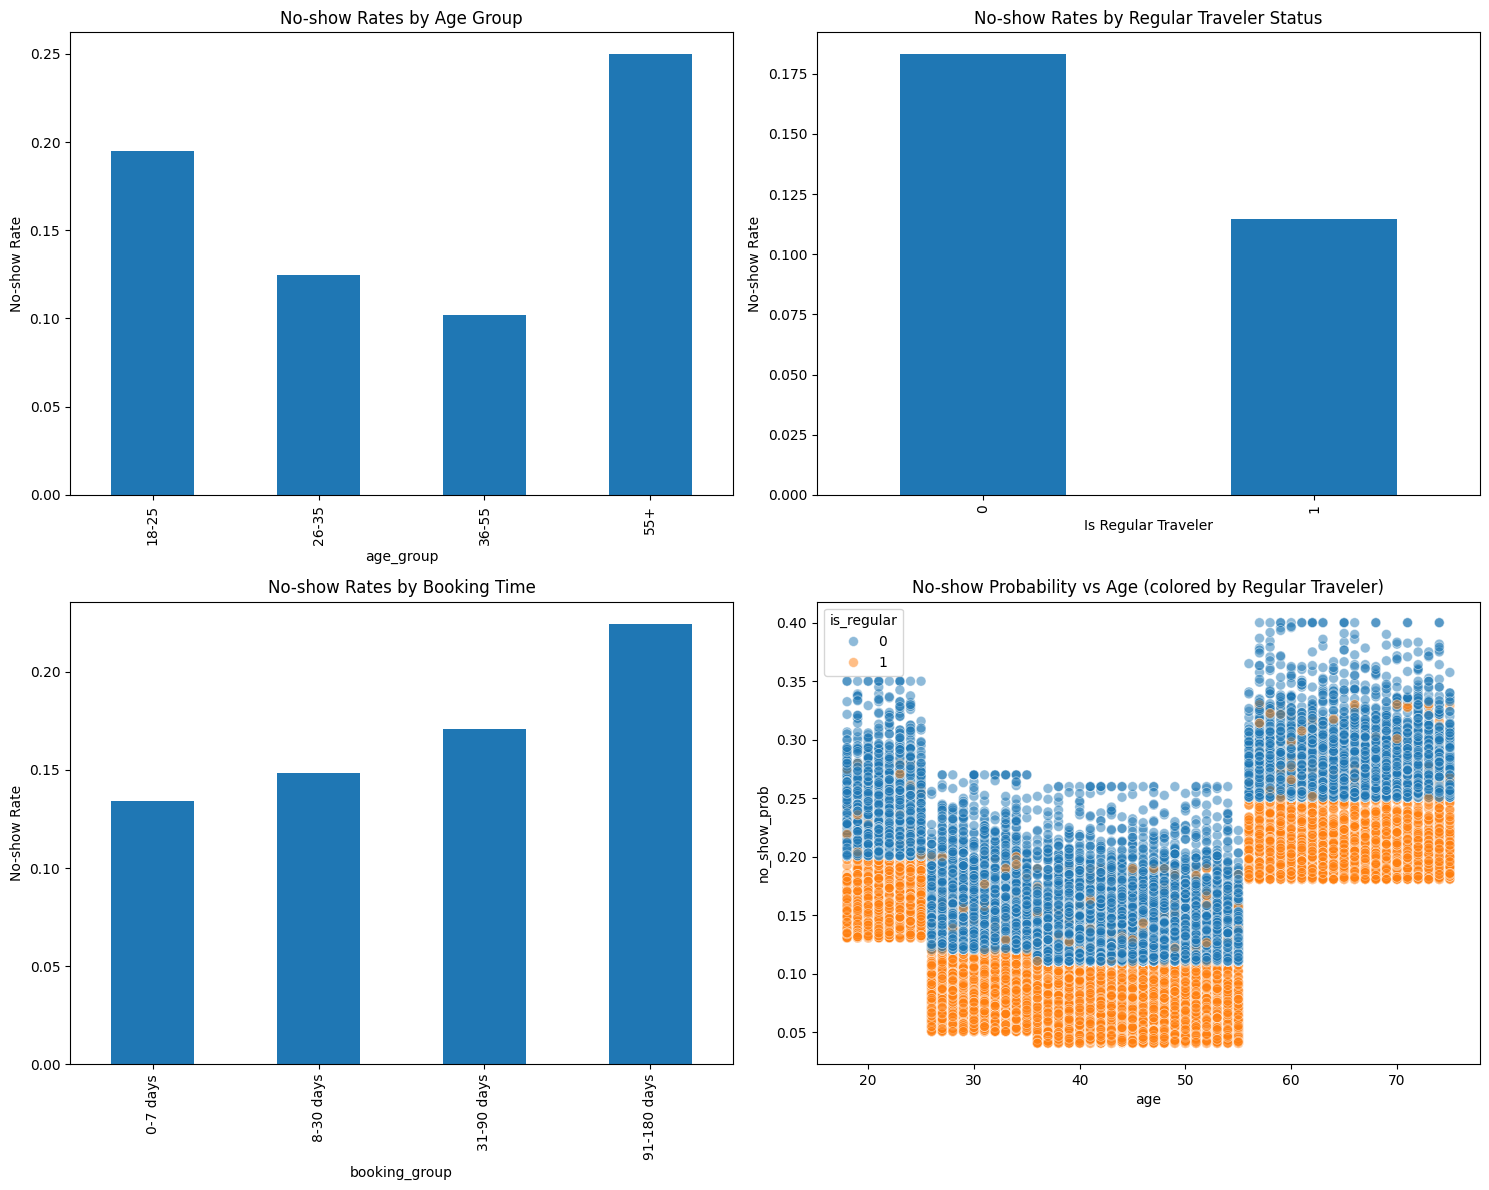

In [1]:
#DATASET GENERATION


import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

def generate_pnr_dataset(n_passengers=50000, seed=42):

    np.random.seed(seed)

    # Generate PNR numbers
    pnr_base = 10000000
    pnr_numbers = [f'PNR{pnr_base + i}' for i in range(n_passengers)]

    # Generate age
    age_groups = [
        (18, 25, 0.20),
        (26, 35, 0.25),
        (36, 55, 0.35),
        (56, 75, 0.20)
    ]

    ages = []
    for _ in range(n_passengers):
        group = np.random.choice(len(age_groups), p=[g[2] for g in age_groups])
        min_age, max_age, _ = age_groups[group]
        ages.append(np.random.uniform(min_age, max_age))
    ages = np.array(ages)

    # Generate regular traveler status
    is_regular = np.random.choice([0, 1], size=n_passengers, p=[0.6, 0.4])

    # Generate days_before_flight
    days_before_flight = np.random.exponential(scale=30, size=n_passengers)
    days_before_flight = np.clip(days_before_flight, 1, 180).astype(int)

    # Calculate no-show probability for each passenger
    def calculate_no_show_prob(age, is_regular, days_before):

        # Age effect
        if age <= 25:
            age_effect = 0.10
        elif age <= 35:
            age_effect = 0.02
        elif age <= 55:
            age_effect = 0.01
        else:
            age_effect = 0.15

        # Regular traveler effect
        regular_effect = -0.07 if is_regular == 1 else 0.0

        # Days before flight effect
        days_effect = 0.15 * (days_before / 180)

        # Combine effects
        base_prob = 0.10
        prob = base_prob + age_effect + regular_effect + days_effect
        return np.clip(prob, 0.01, 0.50)  # Ensure probability is between 1% and 50% to actually make sense

    # Apply the function to all passengers
    no_show_prob = np.array([calculate_no_show_prob(age, reg, days)
                             for age, reg, days in zip(ages, is_regular, days_before_flight)])

    # Generate actual no-show outcomes
    no_show = np.random.binomial(1, no_show_prob)


    df = pd.DataFrame({
        'PNR': pnr_numbers,
        'age': ages.round(0).astype(int),
        'is_regular': is_regular,
        'days_before_flight': days_before_flight,
        'no_show_prob': no_show_prob,
        'no_show': no_show
    })

    return df

def analyze_correlations(df):

    # Create age groups for analysis
    df['age_group'] = pd.cut(df['age'],
                            bins=[0, 25, 35, 55, 100],
                            labels=['18-25', '26-35', '36-55', '55+'])

    # Calculate no-show rates by different factors
    age_group_rates = df.groupby('age_group')['no_show'].mean()
    regular_rates = df.groupby('is_regular')['no_show'].mean()

    # Create booking time groups
    df['booking_group'] = pd.cut(df['days_before_flight'],
                                bins=[0, 7, 30, 90, 180],
                                labels=['0-7 days', '8-30 days', '31-90 days', '91-180 days'])
    booking_rates = df.groupby('booking_group')['no_show'].mean()

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Age group no-show rates
    age_group_rates.plot(kind='bar', ax=axes[0,0], title='No-show Rates by Age Group')
    axes[0,0].set_ylabel('No-show Rate')

    # Regular traveler no-show rates
    regular_rates.plot(kind='bar', ax=axes[0,1], title='No-show Rates by Regular Traveler Status')
    axes[0,1].set_xlabel('Is Regular Traveler')
    axes[0,1].set_ylabel('No-show Rate')

    # Booking time no-show rates
    booking_rates.plot(kind='bar', ax=axes[1,0], title='No-show Rates by Booking Time')
    axes[1,0].set_ylabel('No-show Rate')

    # Scatter plot of age vs no-show probability
    sns.scatterplot(data=df, x='age', y='no_show_prob', hue='is_regular', ax=axes[1,1],
                    alpha=0.5, s=50)
    axes[1,1].set_title('No-show Probability vs Age (colored by Regular Traveler)')

    plt.tight_layout()

# Generate dataset
df = generate_pnr_dataset(50000)

# Print summary statistics
print("\nDataset Summary:")
print("-" * 50)
print(f"Total passengers: {len(df)}")
print(f"\nOverall no-show rate: {df['no_show'].mean():.1%}")

print("\nNo-show rates by age group:")
age_groups = df.groupby(pd.cut(df['age'], [0, 25, 35, 55, 100]))['no_show'].mean()
print(age_groups)

print("\nNo-show rates by regular traveler status:")
print(df.groupby('is_regular')['no_show'].mean())

print("\nNo-show rates by booking time:")
booking_groups = df.groupby(pd.cut(df['days_before_flight'], [0, 7, 30, 90, 180]))['no_show'].mean()
print(booking_groups)

# Save to CSV
df.to_csv('final3.csv', index=False)
print("\nDataset saved to 'pnr_dataset.csv'")

# Analyze correlations
analyze_correlations(df)


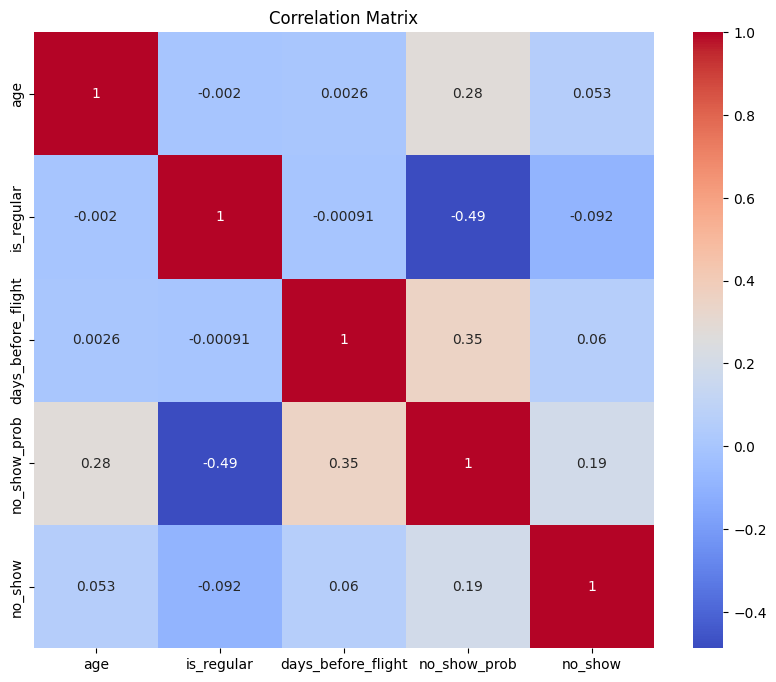

Selected Features: ['no_show_prob']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8414

Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      4207
           1       0.00      0.00      0.00       793

    accuracy                           0.84      5000
   macro avg       0.42      0.50      0.46      5000
weighted avg       0.71      0.84      0.77      5000



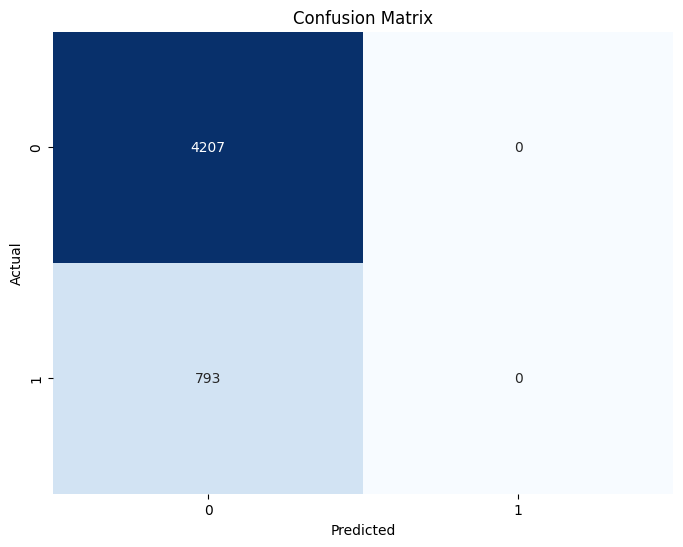

In [2]:
#LOGISTIC REGRESSION



import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'final3.csv'
data = pd.read_csv(file_path)


# Select numerical features for normalization
numerical_features = ['is_regular', 'age', 'days_before_flight']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


numerical_data = data.select_dtypes(include=['number']) # Select only numerical columns for correlation

correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Selection based on Correlation
# Selecting features that have a significant correlation with 'no_show'

threshold = 0.1
correlated_features = correlation_matrix['no_show'].abs() > threshold
# Use correlated_features as a boolean index directly on numerical_data.columns
selected_features = numerical_data.columns[correlated_features].tolist()
selected_features.remove('no_show')  # Remove the target variable from the features

# Print the selected features to check if they are correctly selected
print("Selected Features:", selected_features)

# Check if selected_features is empty and handle it
if not selected_features:
    print("No features selected based on the correlation threshold. Please adjust the threshold or consider other feature selection methods.")
    # You might want to exit or handle this case differently based on your needs
else:
    X = data[selected_features]
    y = data['no_show']

    # Train Logistic Regression Model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)

    # Visualization: Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Training Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.79      0.86     37996
           1       0.38      0.70      0.50      7004

    accuracy                           0.78     45000
   macro avg       0.66      0.75      0.68     45000
weighted avg       0.85      0.78      0.80     45000


Test Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      4222
           1       0.20      0.34      0.25       778

    accuracy                           0.69      5000
   macro avg       0.53      0.55      0.53      5000
weighted avg       0.76      0.69      0.72      5000



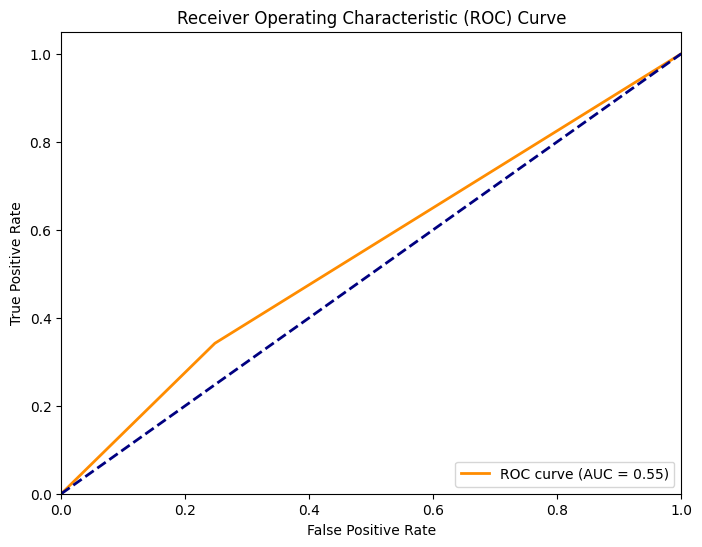

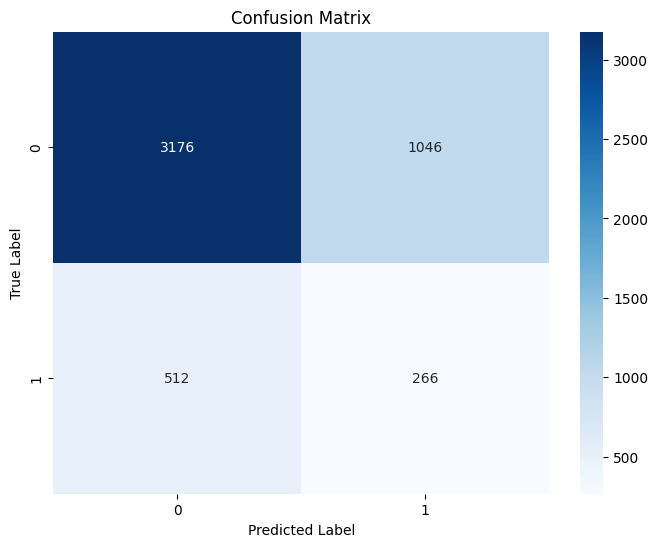

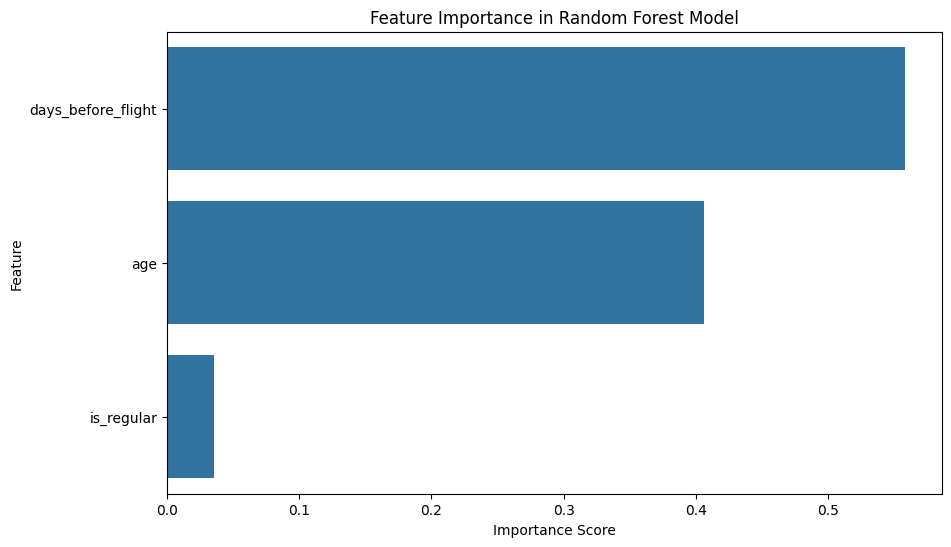


Example Predictions:
--------------------------------------------------

Passenger Profile:
Age: 25
Regular Traveler: No
Days Before Flight: 90
Predicted No-show Probability: 70.8%

Passenger Profile:
Age: 45
Regular Traveler: Yes
Days Before Flight: 7
Predicted No-show Probability: 66.1%

Passenger Profile:
Age: 65
Regular Traveler: No
Days Before Flight: 30
Predicted No-show Probability: 62.5%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid fea


Cross-validation ROC-AUC scores: [0.55945014 0.55754988 0.552572   0.56303766 0.55073186]
Mean ROC-AUC: 0.557 (+/- 0.009)


In [4]:
#RANDOM FORECT


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('final3.csv')

def prepare_data(df):

    X = df[['age', 'is_regular', 'days_before_flight']]
    y = df['no_show']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42
    )

    rf_model.fit(X_train, y_train)
    return rf_model

def evaluate_model(model, X_train, X_test, y_train, y_test):


    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]


    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred))
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_test_pred))


    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return y_test_prob

def analyze_feature_importance(model, feature_names):

    importance = model.feature_importances_


    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance in Random Forest Model')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    return feature_importance

def predict_no_show_probability(model, scaler, age, is_regular, days_before_flight):


    input_data = np.array([[age, is_regular, days_before_flight]])

    input_scaled = scaler.transform(input_data)

    no_show_prob = model.predict_proba(input_scaled)[0][1]

    return no_show_prob

X_train, X_test, y_train, y_test, scaler = prepare_data(df)

rf_model = train_random_forest(X_train, y_train)

y_test_prob = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

feature_importance = analyze_feature_importance(rf_model, X_train.columns)

# Example predictions
print("\nExample Predictions:")
print("-" * 50)
test_cases = [
    {'age': 25, 'is_regular': 0, 'days_before_flight': 90},
    {'age': 45, 'is_regular': 1, 'days_before_flight': 7},
    {'age': 65, 'is_regular': 0, 'days_before_flight': 30}
]

for case in test_cases:
    prob = predict_no_show_probability(rf_model, scaler, case['age'],
                                     case['is_regular'], case['days_before_flight'])
    print(f"\nPassenger Profile:")
    print(f"Age: {case['age']}")
    print(f"Regular Traveler: {'Yes' if case['is_regular'] else 'No'}")
    print(f"Days Before Flight: {case['days_before_flight']}")
    print(f"Predicted No-show Probability: {prob:.1%}")

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print("\nCross-validation ROC-AUC scores:", cv_scores)
print(f"Mean ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:01:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Test Set Performance with Threshold = 0.25
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      8444
           1       0.25      0.22      0.23      1556

    accuracy                           0.78     10000
   macro avg       0.56      0.55      0.55     10000
weighted avg       0.77      0.78      0.77     10000



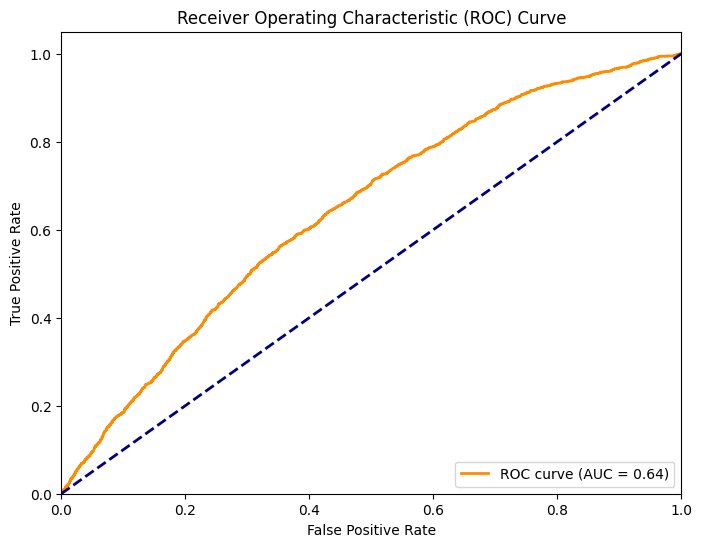

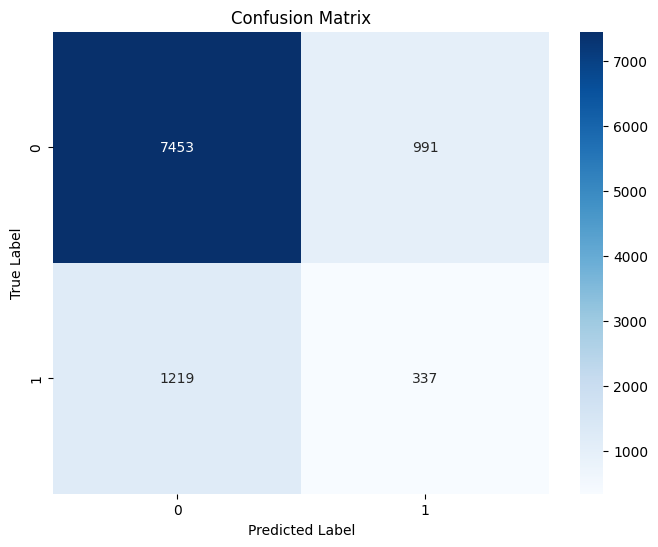

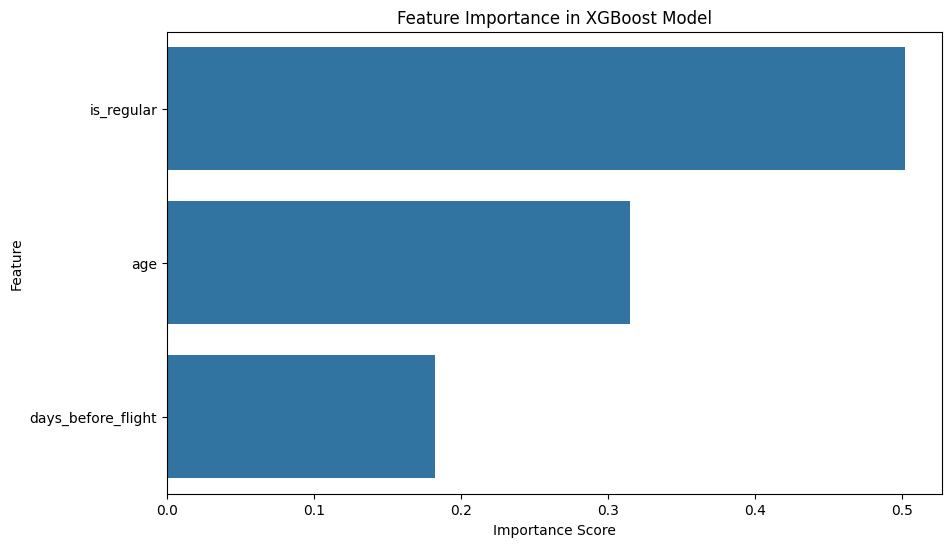


Example Predictions (Threshold = 0.3):
--------------------------------------------------

Passenger Profile:
Age: 25
Regular Traveler: No
Days Before Flight: 40
Predicted No-show: No
Predicted Probability: 21.9%

Passenger Profile:
Age: 45
Regular Traveler: No
Days Before Flight: 20
Predicted No-show: No
Predicted Probability: 11.9%

Passenger Profile:
Age: 65
Regular Traveler: No
Days Before Flight: 30
Predicted No-show: Yes
Predicted Probability: 25.5%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:01:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:01:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboo


Cross-validation ROC-AUC scores: [0.64236927 0.63196157 0.64947411 0.65446835 0.63105943]
Mean ROC-AUC: 0.642 (+/- 0.019)


In [15]:
# XG BOOST



import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('final3.csv')

def prepare_data(df):
    X = df[['age', 'is_regular', 'days_before_flight']]
    y = df['no_show']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def train_xgboost(X_train, y_train):
    xgb_model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=None,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    xgb_model.fit(X_train, y_train)
    return xgb_model

def evaluate_model_with_threshold(model, X_test, y_test, threshold=0.5):
    # Predict probabilities
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Apply custom threshold
    y_test_pred = (y_test_prob >= threshold).astype(int)

    print("\nTest Set Performance with Threshold =", threshold)
    print(classification_report(y_test, y_test_pred))

    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return y_test_pred

def analyze_feature_importance(model, feature_names):
    importance = model.feature_importances_

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance in XGBoost Model')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    return feature_importance

def predict_no_show(model, scaler, age, is_regular, days_before_flight, threshold=0.25):
    input_data = np.array([[age, is_regular, days_before_flight]])
    input_scaled = scaler.transform(input_data)
    no_show_prob = model.predict_proba(input_scaled)[0][1]
    no_show_pred = int(no_show_prob >= threshold)  # Apply threshold
    return no_show_pred,no_show_prob

# Prepare the data
X_train, X_test, y_train, y_test, scaler = prepare_data(df)

# Train the XGBoost model
xgb_model = train_xgboost(X_train, y_train)

# Evaluate the model with custom threshold
y_test_pred = evaluate_model_with_threshold(xgb_model, X_test, y_test, threshold=0.25)

# Analyze feature importance
feature_importance = analyze_feature_importance(xgb_model, X_train.columns)

# Example predictions with adjusted threshold
print("\nExample Predictions (Threshold = 0.3):")
print("-" * 50)
test_cases = [
    {'age': 25, 'is_regular': 0, 'days_before_flight': 40},
    {'age': 45, 'is_regular': 0, 'days_before_flight': 20},
    {'age': 65, 'is_regular': 0, 'days_before_flight': 30}
]

for case in test_cases:
    prediction,prob = predict_no_show(xgb_model, scaler, case['age'],
                                 case['is_regular'], case['days_before_flight'],
                                 threshold=0.25)
    print(f"\nPassenger Profile:")
    print(f"Age: {case['age']}")
    print(f"Regular Traveler: {'Yes' if case['is_regular'] else 'No'}")
    print(f"Days Before Flight: {case['days_before_flight']}")
    print(f"Predicted No-show: {'Yes' if prediction == 1 else 'No'}")
    print(f"Predicted Probability: {prob:.1%}")

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print("\nCross-validation ROC-AUC scores:", cv_scores)
print(f"Mean ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


In [8]:
#TESTING SAMPLE


import pandas as pd
import numpy as np
import sys

def predict_no_show(xgb_model, scaler, age, is_regular, days_before_flight, threshold=0.3):
    input_data = np.array([[age, is_regular, days_before_flight]])
    input_scaled = scaler.transform(input_data)
    no_show_prob = xgb_model.predict_proba(input_scaled)[0][1]
    no_show_pred = int(no_show_prob >= threshold)
    return no_show_pred, no_show_prob

def main():
    # Load the airlines dataset
    df = pd.read_csv('airlines_passenger_data.csv')


    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBClassifier

    scaler = StandardScaler()
    X = df[['age', 'is_regular', 'days_before_flight']]
    scaler.fit(X)



    # Apply predictions
    df['no_show_prediction'], df['no_show_probability'] = zip(*df.apply(
        lambda row: predict_no_show(
            xgb_model,
            scaler,
            row['age'],
            row['is_regular'],
            row['days_before_flight']
        ),
        axis=1
    ))

    # Save updated dataset
    df.to_csv('airlines_passenger_data_with_predictions.csv', index=False)

    # Print summary
    print("Prediction Summary:")
    print(df['no_show_prediction'].value_counts(normalize=True))

if __name__ == "__main__":
    main()

Prediction Summary:
no_show_prediction
0    0.91
1    0.09
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 

In [10]:
#AVERAGE NO SHOW


import pandas as pd

# Load the CSV file
df = pd.read_csv('airlines_passenger_data_with_predictions.csv')


no_show_column = 'no_show_prediction'

# Calculate the average of the 'no_show' column
average_no_show = df[no_show_column].mean()

# Print the average
print(f"The average no-show rate is: {average_no_show:.2f}")


The average no-show rate is: 0.09


In [11]:
import numpy as np
from scipy.stats import binom


total_seats = 100
seat_price = 300
bump_cost = 500
no_show_prob = average_no_show
max_overbooking = 20

# Function to calculate expected profit for a given number of tickets sold
def calculate_expected_profit(tickets_sold):
    expected_profit = 0

    for show_ups in range(tickets_sold + 1):

        show_up_prob = binom.pmf(show_ups, tickets_sold, 1 - no_show_prob)
        revenue = min(total_seats, show_ups) * seat_price
        overcost = max(0, show_ups - total_seats) * bump_cost
        profit = revenue - overcost
        expected_profit += profit * show_up_prob

    return expected_profit

# Find the optimal number of tickets to sell
def find_optimal_tickets():
    best_tickets = total_seats
    max_expected_profit = 0

    for tickets_sold in range(total_seats, total_seats + max_overbooking + 1):
        expected_profit = calculate_expected_profit(tickets_sold)
        print(f"Tickets Sold: {tickets_sold}, Expected Profit: {expected_profit:.2f}")

        if expected_profit > max_expected_profit:
            max_expected_profit = expected_profit
            best_tickets = tickets_sold

    return best_tickets, max_expected_profit
optimal_tickets, max_profit = find_optimal_tickets()
print(f"\nOptimal Tickets to Sell: {optimal_tickets}")
print(f"Maximum Expected Profit: {max_profit:.2f}")

Tickets Sold: 100, Expected Profit: 27300.00
Tickets Sold: 101, Expected Profit: 27572.94
Tickets Sold: 102, Expected Profit: 27845.36
Tickets Sold: 103, Expected Profit: 28115.39
Tickets Sold: 104, Expected Profit: 28378.11
Tickets Sold: 105, Expected Profit: 28623.89
Tickets Sold: 106, Expected Profit: 28837.98
Tickets Sold: 107, Expected Profit: 29002.13
Tickets Sold: 108, Expected Profit: 29098.23
Tickets Sold: 109, Expected Profit: 29112.42
Tickets Sold: 110, Expected Profit: 29038.14
Tickets Sold: 111, Expected Profit: 28877.07
Tickets Sold: 112, Expected Profit: 28637.89
Tickets Sold: 113, Expected Profit: 28333.69
Tickets Sold: 114, Expected Profit: 27979.07
Tickets Sold: 115, Expected Profit: 27587.83
Tickets Sold: 116, Expected Profit: 27171.53
Tickets Sold: 117, Expected Profit: 26739.02
Tickets Sold: 118, Expected Profit: 26296.57
Tickets Sold: 119, Expected Profit: 25848.29
Tickets Sold: 120, Expected Profit: 25396.76

Optimal Tickets to Sell: 109
Maximum Expected Profit: 

Tickets Sold: 100, Expected Profit: 27300.00
Tickets Sold: 101, Expected Profit: 27572.94
Tickets Sold: 102, Expected Profit: 27845.36
Tickets Sold: 103, Expected Profit: 28115.39
Tickets Sold: 104, Expected Profit: 28378.11
Tickets Sold: 105, Expected Profit: 28623.89
Tickets Sold: 106, Expected Profit: 28837.98
Tickets Sold: 107, Expected Profit: 29002.13
Tickets Sold: 108, Expected Profit: 29098.23
Tickets Sold: 109, Expected Profit: 29112.42
Tickets Sold: 110, Expected Profit: 29038.14
Tickets Sold: 111, Expected Profit: 28877.07
Tickets Sold: 112, Expected Profit: 28637.89
Tickets Sold: 113, Expected Profit: 28333.69
Tickets Sold: 114, Expected Profit: 27979.07
Tickets Sold: 115, Expected Profit: 27587.83
Tickets Sold: 116, Expected Profit: 27171.53
Tickets Sold: 117, Expected Profit: 26739.02
Tickets Sold: 118, Expected Profit: 26296.57
Tickets Sold: 119, Expected Profit: 25848.29
Tickets Sold: 120, Expected Profit: 25396.76


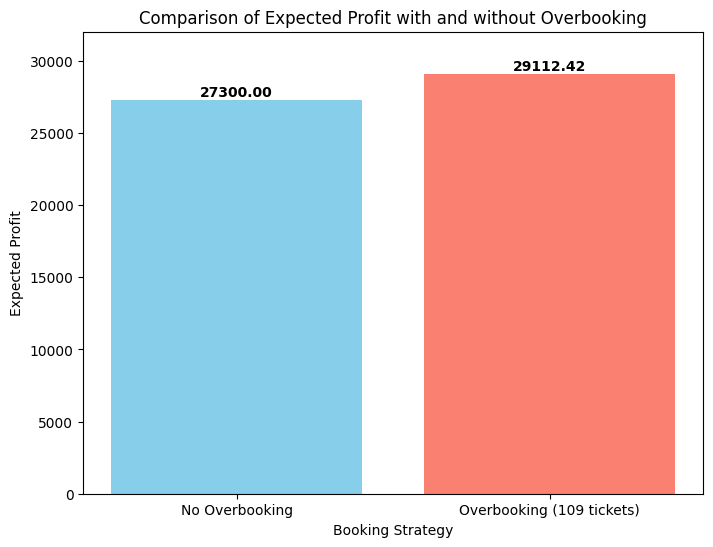

In [12]:
# Booking Strategy


import matplotlib.pyplot as plt


def profit_without_overbooking():
    return calculate_expected_profit(total_seats)


optimal_tickets, max_profit_with_overbooking = find_optimal_tickets()
profit_no_overbooking = profit_without_overbooking()


def plot_profit_comparison():
    profits = [profit_no_overbooking, max_profit_with_overbooking]
    labels = ['No Overbooking', f'Overbooking ({optimal_tickets} tickets)']
    colors = ['skyblue', 'salmon']

    plt.figure(figsize=(8, 6))
    plt.bar(labels, profits, color=colors)
    plt.xlabel("Booking Strategy")
    plt.ylabel("Expected Profit")
    plt.title("Comparison of Expected Profit with and without Overbooking")
    plt.ylim(0, max(profits) * 1.1)
    plt.text(0, profit_no_overbooking, f"{profit_no_overbooking:.2f}", ha='center', va='bottom', fontweight='bold')
    plt.text(1, max_profit_with_overbooking, f"{max_profit_with_overbooking:.2f}", ha='center', va='bottom', fontweight='bold')

    plt.show()


plot_profit_comparison()


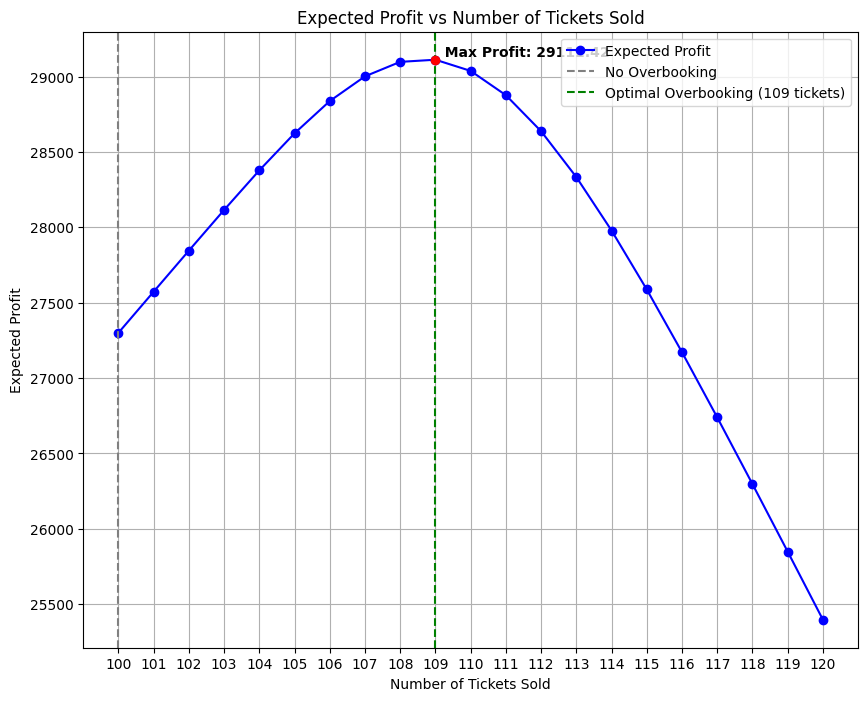

In [16]:
#Optimal booking


def calculate_profits_over_range():
    ticket_levels = list(range(total_seats, total_seats + max_overbooking + 1))
    expected_profits = [calculate_expected_profit(tickets_sold) for tickets_sold in ticket_levels]
    return ticket_levels, expected_profits


def plot_expected_profit_over_range():

    ticket_levels, expected_profits = calculate_profits_over_range()

    optimal_index = np.argmax(expected_profits)
    optimal_tickets = ticket_levels[optimal_index]
    max_profit = expected_profits[optimal_index]


    plt.figure(figsize=(10, 8))
    plt.plot(ticket_levels, expected_profits, marker='o', color='b', label='Expected Profit')
    plt.axvline(x=total_seats, color='gray', linestyle='--', label='No Overbooking')
    plt.axvline(x=optimal_tickets, color='green', linestyle='--', label=f'Optimal Overbooking ({optimal_tickets} tickets)')

    plt.scatter(optimal_tickets, max_profit, color='red', zorder=5)
    plt.text(optimal_tickets, max_profit, f"  Max Profit: {max_profit:.2f}", va='bottom', fontweight='bold')

    plt.xticks(ticket_levels)

    plt.xlabel("Number of Tickets Sold")
    plt.ylabel("Expected Profit")
    plt.title("Expected Profit vs Number of Tickets Sold")
    plt.legend()
    plt.grid()

    plt.show()

plot_expected_profit_over_range()